In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

In [4]:
class SOM(object):
    
    def __init__(self, n_neurons, n_epochs, lr = None, radius = None):
        pass
        
        if n_neurons is None:
            self.n_neurons = 5 * int(np.sqrt(self.n_features)) # 5 * floor(sqrt(n_features))
        
        else:
            self.n_neurons = n_neurons
        
        self.n_epochs = n_epochs
        self.random_state = np.random.mtrand._rand
        
        #learning rate
        if lr is None:
            self.lr_0 = 0.9
            self.lr_1 = 0.1
            
        
        else:
            self.lr_0, self.lr_1 = lr
        
        self.lambda_lr = self.n_epochs / (-1 * np.log(self.lr_1 / self.lr_0))
        
        #radius
        if radius is None:
            self.radius_0 = 1
            self.radius_1 = 0.01
            
        
        else:
            self.radius_0, self.radius_1 = radius
        
        self.lambda_radius = self.n_epochs / (-1 * np.log(self.radius_1 / self.radius_0))
        
        #create grid
        self.create_grid()
    
    def create_grid(self):
        
        X, Y = np.meshgrid(np.arange(0, self.n_neurons, 1), np.arange(0, self.n_neurons, 1))
        
        self.grid_points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        
    def exponential_scheduler(self, epoch, lr_flag = True):
        
        if lr_flag:
            lambda_val = self.lambda_lr
            N0 = self.lr_0
        
        else:
            lambda_val = self.lambda_radius
            N0 = self.radius_0
            
        return N0 * np.exp(- epoch / lambda_val)
    
    @staticmethod
    def euclidean_distance(x0, x1):
        
        return np.sqrt(np.sum((x0 - x1)**2))
    
    @staticmethod
    def euclidean_neighbourhood(d_ci, radius_t):
        
        return np.exp(-1 * (d_ci**2) / (2 * radius_t**2))
    
    
    def initialise_weights(self):
        
        return np.random.randn(self.n_neurons, self.n_features)
    
    def fit(self, X):
        
        n_samples, self.n_features = X.shape
        
        #Initialise problem
        self.t = 0
        weights = self.initialise_weights()
        
        while self.t < self.n_epochs:
            
            #Select random vector
            random_index = self.random_state.randint(0, 100)
            x_selected = X[random_index, :]
            
            #Compute distance
            d = np.zeros(self.n_neurons)
            
            for i in range(self.n_neurons):
                d[i] = self.euclidean_distance(weights[i, :], x_selected)
            
            #Select BMU
            c_index = np.argmin(d)
            
            #Calculate radius and learning_rate
            lr_t = self.exponential_scheduler(self.t, lr_flag = True)
            radius_t = self.exponential_scheduler(self.t, lr_flag = False)
            
            #Update weights
            for i in range(self.n_neurons):
                d_ci = self.euclidean_distance(self.grid_points[c_index, :], self.grid_points[i, :])
                
                scale = self.euclidean_neighbourhood(d_ci, radius_t)
                
                weights[i, :] += lr_t * scale * (x_selected - weights[i, :])
            
            #Update time
            self.t += 1
            
            #plt.figure()
            #plt.scatter(X[:, 0], X[:, 1])
            #plt.scatter(weights[:, 0], weights[:, 1], color = "r", marker = "x")
            #plt.show()
        
        self.weights_ = weights
        
        return self
        
        
        

[[2.  0.5]
 [0.5 1. ]]


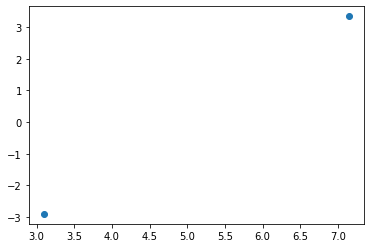


Covariance is positive definite.
(1000, 2)


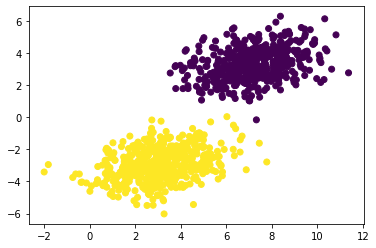

In [21]:
sample_blobs = sample_random_balls(2, var_x = 2, var_y = 1, var_xy = 0.5)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(1000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

455.11961331341877 434.2944819032519 0.1


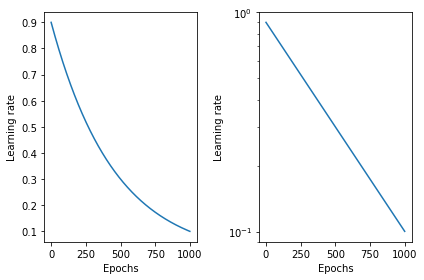

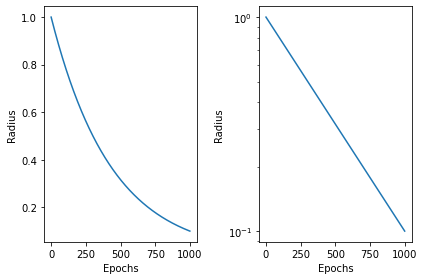

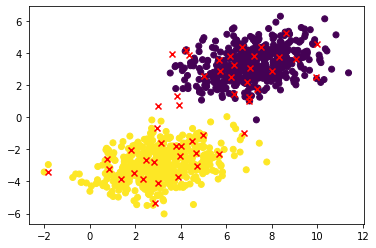

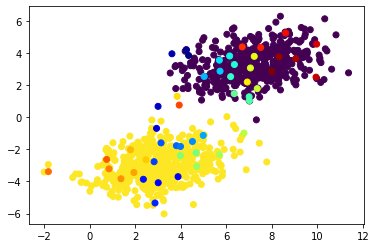

In [22]:
SOM_instance = SOM(n_neurons = 50, n_epochs = 1000, lr = [0.9, 0.1], radius = [1, 0.1])

print(SOM_instance.lambda_lr, SOM_instance.lambda_radius, SOM_instance.lr_1)

epochs = np.arange(0, SOM_instance.n_epochs, 1)
    
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = True))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Learning rate")

ax[1].semilogy(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = True))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Learning rate")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = False))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Radius")

ax[1].semilogy(epochs, SOM_instance.exponential_scheduler(epochs, lr_flag = False))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Radius")
plt.tight_layout()
plt.show()

#Normalise data
mean = np.mean(x, axis = 0)
std = np.std(x, axis = 0)
x_train = (x - mean) / std

#Fit model
SOM_instance.fit(x_train)

#Rescale weights
weights = SOM_instance.weights_ * std + mean

#Visualise
plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(weights[:, 0], weights[:, 1], color = "r", marker = "x")
plt.show()

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(weights[:, 0], weights[:, 1], c = np.arange(weights.shape[0]), cmap = plt.cm.jet)
plt.show()